In [2]:


from sklearn import linear_model
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")




raw_data = pd.read_csv("compas-scores-two-years.csv")
print('(#people, #features) =', raw_data.shape)


allowed_factors = [
    #'id',
    #'name',
    #'first',
    #'last',
    #'compas_screening_date',
    #'sex',
    #'dob',
    #'age_cat',
    'race',
    'decile_score', #COMPAS score
    'age',
    'juv_fel_count', 
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    #'days_b_screening_arrest', propublica uses this to filter data
    #  'c_jail_in', date
    #  'c_jail_out', date
    #  'c_case_number',
    #  'c_offense_date',
    #  'c_arrest_date',
    #  'c_days_from_compas',
    'c_charge_degree', #Misdemeanor or felony for original charge, need to make categorical
    #'c_charge_desc',
    'is_recid', 
    #'r_case_number',
    'r_charge_degree',#Misdemeanor or felony of re-offense, need to make categorical
    #  'r_days_from_arrest',
    #  'r_offense_date',
    #  'r_charge_desc',
    #  'r_jail_in',
    #  'r_jail_out',
    #'violent_recid', #all are NAN
    'is_violent_recid', #hey we can use this for groups!
    #  'vr_case_number',
    'vr_charge_degree', #maybe remove this from r_charge degree
    #  'vr_offense_date',
    #  'vr_charge_desc', #weird that vr_charge_desc and r_charge_desc do not overlap
    #  'type_of_assessment',
    #  'decile_score.1',#same as decile score?
    'score_text',#low, medium, high risk based on COMPAS
    #  'screening_date',
    #  'v_type_of_assessment',
    #  'v_decile_score',
    #  'v_score_text', #low, medium high
    #  'v_screening_date',
    #  'in_custody',
    #  'out_custody',
    #'priors_count.1', #not sure what the dif is from priors_count. it is the same
    #  'start',
    #  'end',
    # 'event', #no clue what this means?!?
    #'two_year_recid' # same as is_recid
] 



predictive_features = [ # comment or uncomment any features to use in logistic regression training
    'age',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    #'c_charge_degree' #<-- not included in COMPAS algorithm
    ]

protected_features = ['race']



df_compas_filt = raw_data.loc[
    (raw_data['is_recid'] != -1) & 
    (raw_data['days_b_screening_arrest'] <= 30) & 
    (raw_data['days_b_screening_arrest'] >= -30) & 
    (raw_data['c_charge_degree'] != 'O') & 
    (raw_data['score_text'] != 'N/A') & 
    (raw_data['race'].isin(['African-American', 'Caucasian']))
][allowed_factors]

# Reset index without creating an 'index' column
df_compas_filt = df_compas_filt.reset_index(drop=True)

print('The dimensions of df_compas_filt are:', df_compas_filt.shape)

# Directly fill missing values in 'r_charge_degree'
df_compas_filt['r_charge_degree'] = df_compas_filt['r_charge_degree'].fillna(0)


def recode_column_values(col, code_dict):
    '''
    Recode the values of a pandas Series based on a provided dictionary.

    Parameters:
    col (pd.Series): Column of DataFrame to change encoding.
    code_dict (dict): Dictionary for encoding, format {'key': value, ...}.
    
    Returns:
    pd.Series: A Series with values recoded based on code_dict.
    '''
    col_coded = col.replace(code_dict)
    return col_coded


# for c_charge_degree, change M(misdomeaner)/F(felony) to 0/1
df_compas_filt["c_charge_degree"] = recode_column_values(df_compas_filt["c_charge_degree"], {'M':0,'F':1})

# for race, change Caucasian/African-American to 0/1


(#people, #features) = (7214, 53)
The dimensions of df_compas_filt are: (5278, 13)


In [36]:
df_compas_filt

,race,decile_score,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,r_charge_degree,is_violent_recid,vr_charge_degree,score_text
0,African-American,3,34,0,0,0,0,1,1,(F3),1,(F3),Low
1,African-American,4,24,0,0,1,4,1,1,(M1),0,NaN,Low
2,Caucasian,6,41,0,0,0,14,1,1,(F2),0,NaN,Medium
3,Caucasian,1,39,0,0,0,0,0,0,0,0,NaN,Low
4,Caucasian,4,27,0,0,0,0,1,0,0,0,NaN,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273,African-American,2,30,0,0,0,0,0,1,(F3),0,NaN,Low
5274,African-American,9,20,0,0,0,0,1,0,0,0,NaN,High
5275,African-American,7,23,0,0,0,0,1,0,0,0,NaN,Medium
5276,African-American,3,23,0,0,0,0,1,0,0,0,NaN,Low


In [4]:
from functions.split_data_function import split_data #split data into train, test, and validation sets

In [5]:
from functions.race_dummy_encoding import race_dummy_encoding

In [3]:
from sklearn.model_selection import train_test_split
import random

def split_data(df, debias_train_size, standard_training_set_percentage, random_state=None):
    '''
    Splits data into testing, training, and debias estimator sets.
    
    Args:
        df (pd.DataFrame): The DataFrame to be split.
        debias_train_size (int): Size of the debias training set, at least 10 times the number of features.
        standard_training_set_percentage (float): Percentage split for train/test of df excluding debias_train_df.
        random_state (int, optional): Random state for reproducibility.
        
    Returns: 
        tuple: (debias_train_df, train_df, test_df) DataFrames.
    '''

    if not 0 < standard_training_set_percentage < 1:
        raise ValueError("standard_training_set_percentage must be between 0 and 1")

    if debias_train_size > df.shape[0]:
        raise ValueError("debias_train_size cannot be greater than the number of rows in the dataframe")

    # Sample for the debiasing training set
    debias_train_df = df.sample(n=debias_train_size, random_state=random_state)
    
    # Drop the debiasing samples from the main dataframe
    df_remaining = df.drop(debias_train_df.index)
    
    # Split the remaining data into training and testing sets
    train_df, test_df = train_test_split(df_remaining, train_size=standard_training_set_percentage, shuffle=True, random_state=random_state)
    
    # Reset index
    test_df = test_df.reset_index(drop=True)
    train_df = train_df.reset_index(drop=True)
    debias_train_df = debias_train_df.reset_index(drop=True)
    
    return debias_train_df, train_df, test_df

In [4]:
def race_dummy_encoding(df, race_column, race_categories):
    """
    Create dummy encoding for two specified race categories in a DataFrame.

    Args:
    df (pd.DataFrame): DataFrame containing the race data.
    race_column (str): Name of the column containing race information.
    race_categories (tuple): A tuple of two strings representing the race categories to be encoded.

    Returns:
    pd.DataFrame: DataFrame with dummy encoding for the specified race categories.
    """

    if not all(category in df[race_column].unique() for category in race_categories):
        raise ValueError("Provided race categories must exist in the DataFrame")

    category_1, category_2 = race_categories

    # Vectorized operation for dummy encoding
    df_encoded = pd.DataFrame({
        category_1: (df[race_column] == category_1).astype(int),
        category_2: (df[race_column] == category_2).astype(int)
    })

    return df_encoded

In [5]:
import numpy as np

def recid_no_recid_index(col, group_elements):
    """
    Finds indices in a column for each specified group element.

    Args:
    col (array-like): The column to search through.
    group_elements (list): List of elements to find in the column.

    Returns:
    list: A list of lists, where each sublist contains the indices of one of the group elements.
    """

    # Using list comprehension for efficient indexing
    group_indices = [list(np.where(col == element)[0]) for element in group_elements]
    
    return group_indices

In [6]:
import numpy as np

def violent_nonviolent_norecid_index(is_violent_recid, is_recid):
    """
    Categorizes indices into violent, non-violent recidivist, and no recidivist.

    Args:
    is_violent_recid (array-like): Array indicating violent recidivism.
    is_recid (array-like): Array indicating any recidivism.

    Returns:
    list: A list containing three lists of indices for violent, non-violent recidivist, and no recidivist.
    """
    # Indices for violent recidivism
    violent_indices = np.where(is_violent_recid == 1)[0]

    # Indices for non-violent recidivism and no recidivism, excluding violent indices
    non_violent_recid_indices = np.where((is_recid == 1) & ~(np.isin(np.arange(len(is_recid)), violent_indices)))[0]
    no_recid_indices = np.where((is_recid == 0) & ~(np.isin(np.arange(len(is_recid)), violent_indices)))[0]

    return [violent_indices, non_violent_recid_indices, no_recid_indices]


In [7]:
import numpy as np

def all_cat_index(vr_charge_degree, r_charge_degree):
    """
    Creates a dictionary of indices for different charge degrees, considering both violent and non-violent charges.

    Args:
    vr_charge_degree (array-like): Array indicating violent recidivism charges.
    r_charge_degree (array-like): Array indicating recidivism charges.

    Returns:
    list: List of indices categorized by charge degrees.
    """

    # Unique charges in violent recidivism
    vr_charges = vr_charge_degree.unique()
    group_dict = {charge: np.where(vr_charge_degree == charge)[0] for charge in vr_charges}

    # Concatenate indices of violent charges to avoid double counting
    violent_indices = np.concatenate([indices for indices in group_dict.values()])

    # Unique charges in recidivism, excluding those already indexed by a violent crime
    r_charges = r_charge_degree.unique()
    non_violent_indices = {charge: r_charge_degree[(r_charge_degree == charge) & ~(np.isin(np.arange(len(r_charge_degree)), violent_indices))].index for charge in r_charges}

    # Merge violent and non-violent charge indices
    group_dict.update({(charge, 'nonV'): indices for charge, indices in non_violent_indices.items()})

    return list(group_dict.values())


In [8]:
import pandas as pd

def center_by_homogeneous_subgroups(group_indices, Y):
    """
    Centers a DataFrame by subtracting the mean of each homogeneous subgroup.

    Args:
        Y (pd.DataFrame): DataFrame to be debiased.
        group_indices (list of lists): Indices of the homogeneous subgroups.

    Returns:
        pd.DataFrame: The centered DataFrame.
    """

    # List to hold centered subgroups
    centered_subgroups = []

    # Center each subgroup and add to the list
    for indices in group_indices:
        subgroup = Y.loc[indices]
        centered_subgroup = subgroup - subgroup.mean()
        centered_subgroups.append(centered_subgroup)

    # Concatenate all centered subgroups and sort by index
    centered_Y = pd.concat(centered_subgroups).sort_index()

    return centered_Y


In [9]:
from sklearn import linear_model

def fit_linear_regression(centered_Y_train, X, fit_intercept=True):
    """
    Fits a linear regression model to the data.

    Args:
    centered_Y_train (array-like): The dependent variable (target) data.
    X (array-like): The independent variable (feature) data.
    fit_intercept (bool): Whether to calculate the intercept for this model.

    Returns:
    tuple: Tuple containing (A_hat, b) where 'A_hat' are the estimated coefficients 
           and 'b' is the estimated intercept.
    """

    # Initialize the linear regression model
    ols = linear_model.LinearRegression(fit_intercept=fit_intercept)

    # Fit the model
    ols.fit(X, centered_Y_train)

    # Extract the coefficients and intercept
    A_hat = ols.coef_
    b = ols.intercept_

    return A_hat, b



In [10]:
from sklearn import linear_model
import numpy as np

from sklearn import linear_model
import numpy as np

def biased_debiased_probs(data, debias_train_size, train_percentage_split, race_categories):
    """
    Calculates the biased and debiased probabilities using logistic regression.

    Args:
    data (pd.DataFrame): The input dataset.
    debias_train_size (int): The size of the training set for debiasing.
    train_percentage_split (float): The percentage split for the training set.
    race_categories (tuple): A tuple representing the race categories to be encoded.

    Returns:
    tuple: Tuple containing probabilities, debiased probabilities, race, decile_score, and is_recid of the test set.
    """

    # Split data into testing, training, and debias training sets
    debias_train_df, train_df, test_df = split_data(data, debias_train_size, train_percentage_split)

    # Dummy encode race for debias training set
    X_dummy_encoding = race_dummy_encoding(debias_train_df, 'race', race_categories)

    # Extract Y for debias training
    Y = debias_train_df[predictive_features]

    # Get group indices
    group_indices = all_cat_index(debias_train_df['vr_charge_degree'], debias_train_df['r_charge_degree'])

    # Center by group indices
    centered_Y_train = center_by_homogeneous_subgroups(group_indices, Y)

    # Estimate coefficients and intercept (A_hat and b)
    A_hat, b = fit_linear_regression(centered_Y_train, X_dummy_encoding, True)
    
    # Dummy encode race for training and testing set
    train_race_dummy = race_dummy_encoding(train_df, 'race', race_categories)
    test_race_dummy = race_dummy_encoding(test_df, 'race', race_categories)
    
    # Prepare training and test sets
    train_features = train_df[predictive_features]
    train_debiased = train_features - np.matmul(train_race_dummy.values, A_hat.T) - b.T

    test_features = test_df[predictive_features]
    test_debiased = test_features - np.matmul(test_race_dummy.values, A_hat.T) - b.T
    
    # Fit logistic regression models
    logit_model = linear_model.LogisticRegression()
    logit_debiased_model = linear_model.LogisticRegression()
    logit_model.fit(train_features, train_df['is_recid'])
    logit_debiased_model.fit(train_debiased, train_df['is_recid'])

    # Predict probabilities
    probs = list(logit_model.predict_proba(test_features)[:, 1])
    probs_debiased = list(logit_debiased_model.predict_proba(test_debiased)[:, 1])

    return probs, probs_debiased, test_df['race'], test_df['decile_score'], test_df['is_recid']



In [11]:
import numpy as np

def FPR(prediction, recid_label):
    """
    Calculates the False Positive Rate (FPR).

    Args:
    prediction (array-like): Array of predicted labels.
    recid_label (array-like): Array of actual labels.

    Returns:
    float: The calculated FPR.
    """
    
    # Convert lists to numpy arrays for vectorized operations
    prediction = np.array(prediction)
    recid_label = np.array(recid_label)

    # Calculate False Positives (FP) and True Negatives (TN)
    FP = np.sum((prediction == 1) & (recid_label == 0))
    TN = np.sum((prediction == 0) & (recid_label == 0))

    # Handle division by zero
    if FP + TN == 0:
        return np.nan  # or return some other value or raise an exception

    return FP / (FP + TN)


In [12]:
def FPR_FNR_accuracy(recid_label, race, score, threshold=0.5):
    """
    Calculates the FPR, FNR for the overall population and by race, along with the accuracy.

    Args:
    recid_label (array-like): Actual labels.
    race (array-like): Race labels (0 for white, 1 for black).
    score (array-like): Predicted scores.
    threshold (float): Threshold for converting scores to binary predictions.

    Returns:
    list: [pop_FPR, pop_FNR, white_FPR, white_FNR, black_FPR, black_FNR]
    float: Accuracy.
    """

    prediction = (np.array(score) >= threshold).astype(int)
    
    pop_FPR = FPR(prediction, recid_label)
    pop_FNR = FNR(prediction, recid_label)

    # Function to extract race-specific metrics
    def race_specific_metrics(race_indices):
        return (
            FPR(prediction[race_indices], recid_label[race_indices]),
            FNR(prediction[race_indices], recid_label[race_indices])
        )

    white_indices = np.where(race == 0)[0]
    black_indices = np.where(race == 1)[0]

    white_FPR, white_FNR = race_specific_metrics(white_indices)
    black_FPR, black_FNR = race_specific_metrics(black_indices)
    
    accuracy = np.mean(prediction == recid_label)

    return [pop_FPR, pop_FNR, white_FPR, white_FNR, black_FPR, black_FNR], accuracy


In [13]:
import numpy as np

def get_logistic_threshold(scores, logistic_quantile=50):
    """
    Calculates the threshold value for logistic regression scores at a specified percentile.

    Args:
    scores (array-like): The logistic regression scores.
    logistic_quantile (int, optional): The percentile at which to calculate the threshold. Defaults to 50.

    Returns:
    float: The calculated threshold value.
    """
    
    if not 0 <= logistic_quantile <= 100:
        raise ValueError("logistic_quantile must be between 0 and 100")

    return np.percentile(scores, logistic_quantile, interpolation='midpoint')


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_prob_hist(probs, race, race_categories):
    """
    Plots histograms of recidivism probabilities for overall population and 
    separately for two specified race categories.

    Args:
    probs (array-like): Probabilities from logistic regression.
    race (array-like): Race labels.
    race_categories (tuple): Tuple of two race categories to be plotted.
    """

    probs = np.array(probs)  # Convert to numpy array for boolean indexing
    category_1, category_2 = race_categories

    print('The average is', np.mean(probs))
    print('The median is', np.median(probs))

    probabilities_group1 = probs[race == category_1]
    probabilities_group2 = probs[race == category_2]

    # Plot overall probabilities
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.hist(probs, bins=25)
    plt.title("Overall Probabilities")
    plt.xlabel("Probability")
    plt.ylabel("Number of People")
    plt.ylim((0, 200))

    # Plot for Group 1
    plt.subplot(1, 3, 2)
    plt.hist(probabilities_group1, bins=25)
    plt.title(f"Probabilities for Group 1 ({category_1})")
    plt.xlabel("Probability")
    plt.ylabel(f"Number of {category_1}")
    plt.ylim((0, 140))

    # Plot for Group 2
    plt.subplot(1, 3, 3)
    plt.hist(probabilities_group2, bins=25)
    plt.title(f"Probabilities for Group 2 ({category_2})")
    plt.xlabel("Probability")
    plt.ylabel(f"Number of {category_2}")
    plt.ylim((0, 140))

    plt.tight_layout()
    plt.show()



In [15]:
race_categories = ('Caucasian', 'African-American')

debias_train_size = 1000
train_percentage_split = 0.6

probs, probs_debiased, race, compas_decile_score, true_label = biased_debiased_probs(
    df_compas_filt, 
    debias_train_size, 
    train_percentage_split,
    race_categories
)

In [67]:
#show columns for probs_debiased




0.5882005982688961

The average is 0.47873420814744205
The median is 0.468825667826931


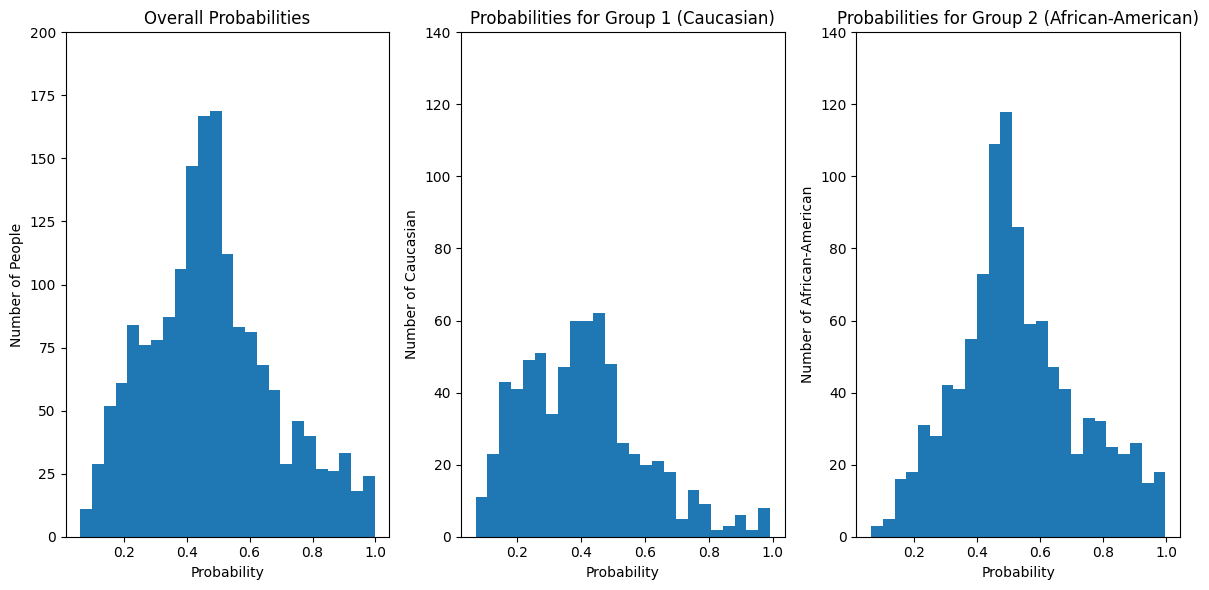

In [16]:
plot_prob_hist(probs, race, race_categories)


The average is 0.47973406371254496
The median is 0.4609909108557979


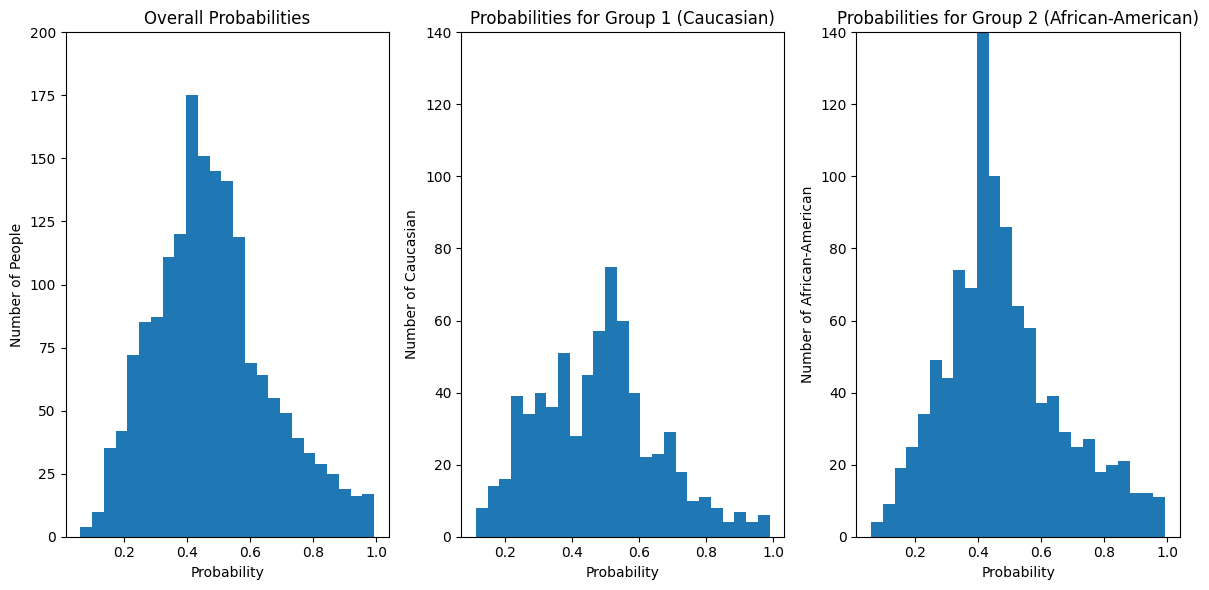

In [37]:
plot_prob_hist(probs_debiased, race, race_categories)

In [68]:
race

0       African-American
1              Caucasian
2              Caucasian
3       African-American
4       African-American
              ...       
1707           Caucasian
1708           Caucasian
1709    African-American
1710    African-American
1711    African-American
Name: race, Length: 1712, dtype: object

1712

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def logistic_histogram_before_after(probs, probs_debiased, race, target_group_label):
    """
    Plots histograms of logistic regression probabilities for a target group before and after debiasing.

    Args:
    probs (array-like): Raw probabilities from logistic regression.
    probs_debiased (array-like): Debiased probabilities from logistic regression.
    race (pandas Series or array-like): Race labels as strings.
    target_group_label (str): The label representing the target group (e.g., 'African-American').
    """

    # Convert probabilities to numpy arrays for efficient indexing
    probs = np.array(probs)
    probs_debiased = np.array(probs_debiased)

    # Extract indices for the target group
    target_group_indices = np.where(race == target_group_label)[0]

    # Extract probabilities for the target group
    probabilities_group = probs[target_group_indices]
    probabilities_group_debias = probs_debiased[target_group_indices]

    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Histogram of Raw Logistic Regression Scores for Target Group
    plt.subplot(1, 2, 1)
    plt.hist(probabilities_group, bins=25)
    plt.title(f"Raw Logistic Regression Scores\n(Target Group: {target_group_label})")
    plt.xlabel("Probability")
    plt.ylabel(f"Number of Individuals in {target_group_label}")
    plt.ylim((0, 140))

    # Histogram of Debiased Logistic Regression Scores for Target Group
    plt.subplot(1, 2, 2)
    plt.hist(probabilities_group_debias, bins=25)
    plt.title(f"Debiased Logistic Regression Scores\n(Target Group: {target_group_label})")
    plt.xlabel("Probability")
    plt.ylabel(f"Number of Individuals in {target_group_label}")
    plt.ylim((0, 140))

    plt.tight_layout()
    plt.show()




In [25]:
def logistic_histogram_before_after_AA(probs, probs_debiased, race):
    probabilities_AA = [probs[i] for i in np.where(race == 1)[0]]
    probabilities_AA_debias = [probs_debiased[i] for i in np.where(race == 1)[0]]
    
    # First set of plots
    plt.hist(probabilities_AA, bins=25)
    plt.title("Histogram of Raw Logistic Regression \n Scores of African-Americans")
    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of African-Americans")
    plt.show()

    plt.hist(probabilities_AA_debias, bins=25)
    plt.title("Histogram of Debiased Logistic Regression \n Scores of African-Americans")
    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of African-Americans")
    plt.tight_layout()
    plt.show()

    # Second set of plots
    ax1 = plt.subplot(121)
    ax1.set_ylim([0, 140])

    plt.subplot(1, 2, 1)
    plt.hist(probabilities_AA, bins=25)
    plt.title("Raw")
    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of African-Americans")

    plt.subplot(1, 2, 2)
    plt.hist(probabilities_AA_debias, bins=25)
    plt.title("Debiased")
    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of African-Americans")
    plt.tight_layout()
    plt.savefig('/mnt/data/histo.pdf', format='pdf', dpi=1000)
    plt.ylim((0, 140))
    plt.show()

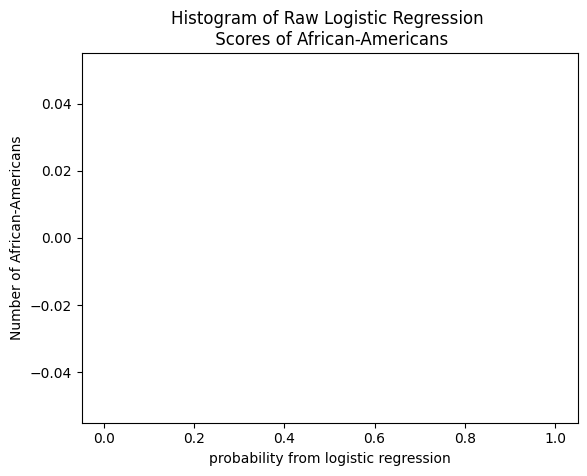

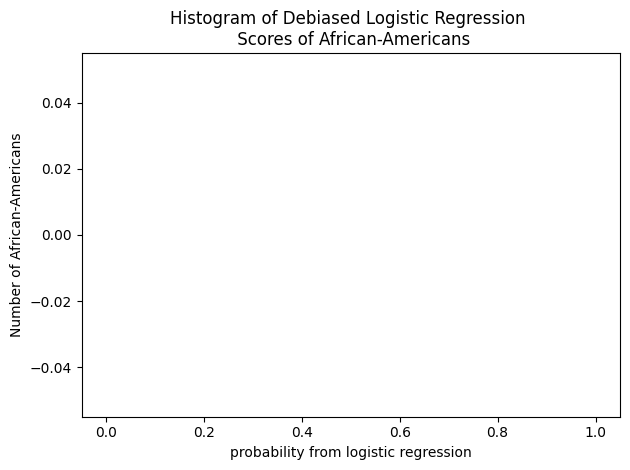

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/histo.pdf'

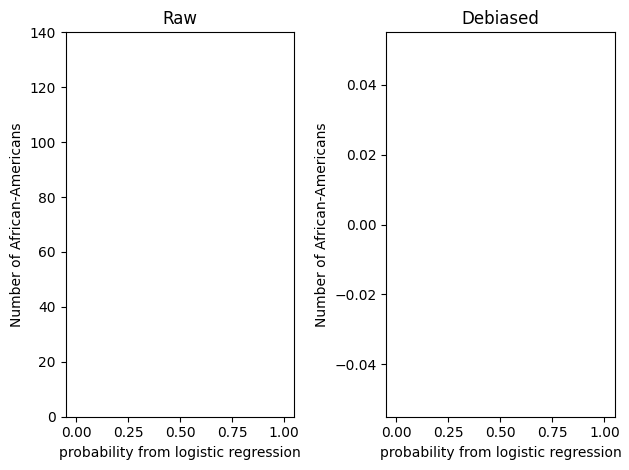

In [27]:
# Assuming 'probs', 'probs_debiased', and 'race' are defined
logistic_histogram_before_after_AA(probs, probs_debiased, race)


In [1]:
len(race)

NameError: name 'race' is not defined

In [34]:
def logistic_histogram_before_after_AA(probs, probs_debiased, race):
    """
    Plots histograms of raw and debiased logistic regression scores for African-Americans,
    where African-Americans are identified in the 'race' array with the label '1'.

    Args:
    probs (array-like or list): Raw probabilities from logistic regression.
    probs_debiased (array-like or list): Debiased probabilities from logistic regression.
    race (array-like): Race labels, where '1' represents African-Americans.
    """

    # Convert probs and probs_debiased to numpy arrays if they are lists
    if isinstance(probs, list):
        probs = np.array(probs)
    if isinstance(probs_debiased, list):
        probs_debiased = np.array(probs_debiased)

    # Extract probabilities for African-Americans using boolean indexing
    AA_bool = (race == 1)
    probabilities_AA = probs[AA_bool]
    probabilities_AA_debias = probs_debiased[AA_bool]

    # Plot histograms
    plt.figure(figsize=(12, 6))

    # Histogram of Raw Logistic Regression Scores for African-Americans
    plt.subplot(1, 2, 1)
    plt.hist(probabilities_AA, bins=25)
    plt.title("Histogram of Raw Logistic Regression \n Scores for African-Americans")
    plt.xlabel("Probability from Logistic Regression")
    plt.ylabel("Number of African-Americans")
    plt.ylim((0, 140))

    # Histogram of Debiased Logistic Regression Scores for African-Americans
    plt.subplot(1, 2, 2)
    plt.hist(probabilities_AA_debias, bins=25)
    plt.title("Histogram of Debiased Logistic Regression \n Scores for African-Americans")
    plt.xlabel("Probability from Logistic Regression")
    plt.ylabel("Number of African-Americans")
    plt.ylim((0, 140))

    plt.tight_layout()
    plt.show()

# Reminder: This function should be run in your notebook environment where 'probs', 'probs_debiased', and 'race' are defined.

# Reminder: This function should be run in your notebook environment where 'probs', 'probs_debiased', and 'race' are defined as separate arrays.

# Reminder: This function should be run in your notebook environment where 'probs', 'probs_debiased', and 'race' are defined as separate arrays.


# Note: This function should be run in your notebook environment where 'probs', 'probs_debiased', and 'race' are defined.


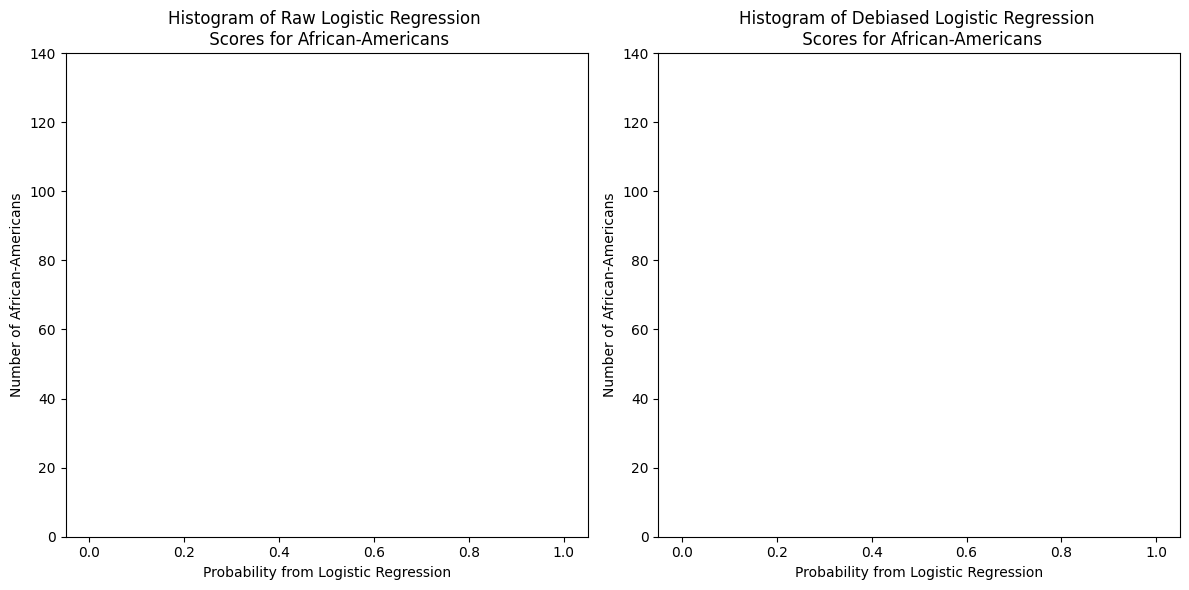

In [35]:
logistic_histogram_before_after_AA(probs, probs_debiased, race)


In [36]:
raw_data = pd.read_csv("./compas-scores-two-years.csv")
print('(#people, #features) =', raw_data.shape)

(#people, #features) = (7214, 53)
